In [ ]:
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
import random

%matplotlib inline


In [2]:
# utility functions
def plot_images(img1, img2, title1='', title2=''):
    ''' 
    plot 2 images side by side. 
    image with one color channel will be plotted as grayscale image
    image with multiple color channels will be treated as BGR and will be converted to RGB before plotting
    '''
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(12,8))
    
    ax1.set_title(title1)
    if len(img1.shape) == 3 and img1.shape[2] == 3:
        ax1.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
    else:
        ax1.imshow(img1, cmap='gray')
    
    ax2.set_title(title2)
    if len(img2.shape) == 3 and img2.shape[2] == 3:
        ax2.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
    else:
        ax2.imshow(img2, cmap='gray')
        
def draw_line(img, pt1, pt2, color=[255, 0, 0], thickness=2):
    ''' draw a line on an image given two endpoints of the line
    '''
    cv2.line(img, (pt1[0], pt1[1]), (pt2[0], pt2[1]), color, thickness)

def draw_trapezoid(img, points):
    ''' draw a trapezoid given the four points
    '''
    draw_line(img, points[0], points[1])
    draw_line(img, points[1], points[2])
    draw_line(img, points[2], points[3])
    draw_line(img, points[3], points[0])
    


## Calibrate Camera

camera matrix [[  1.15396093e+03   0.00000000e+00   6.69705357e+02]
 [  0.00000000e+00   1.14802496e+03   3.85656234e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
distortion coefficients [[ -2.41017956e-01  -5.30721173e-02  -1.15810355e-03  -1.28318856e-04
    2.67125290e-02]]
done..


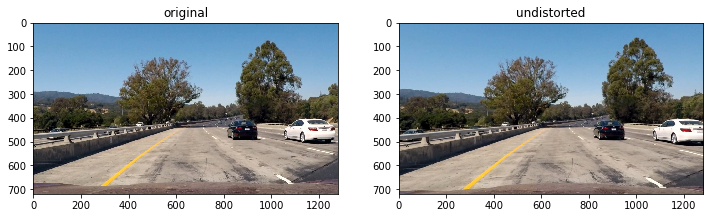

In [3]:
# determine the object points and image points with chessboard images
objpoints = []
imgpoints = []

# prepare object points
nx = 9 #number of inside corners in x
ny = 6 #number of inside corners in y
objp = np.zeros((nx * ny, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

fnames = glob.glob('./camera_cal/calibration*.jpg')

for fname in fnames:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
     # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

image = cv2.imread('test_images/test1.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)        

print('camera matrix', mtx)
print('distortion coefficients', dist)
print('done..')

def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

# display a sample
undistorted_image = cv2.undistort(image, mtx, dist, None, mtx)
plot_images(image, undistorted_image, 'original', 'undistorted')

## Threshold Transform

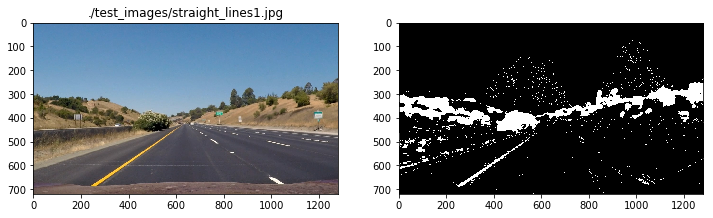

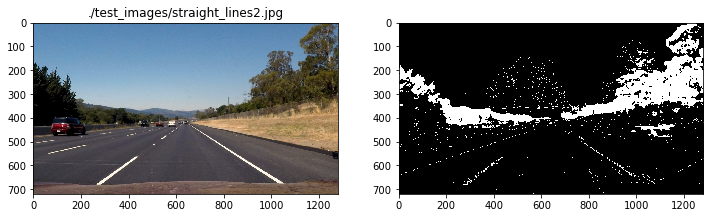

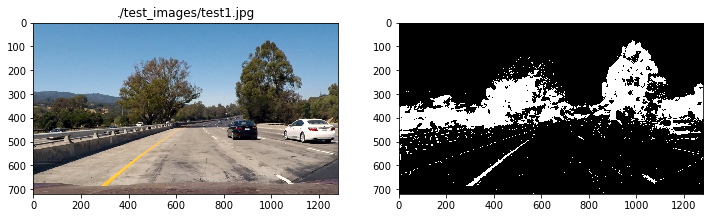

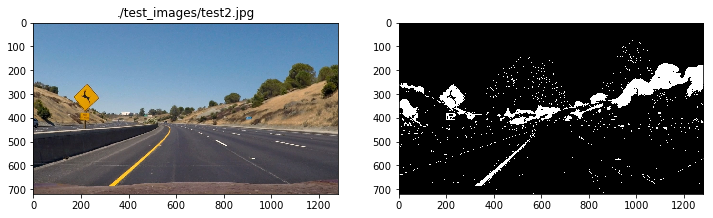

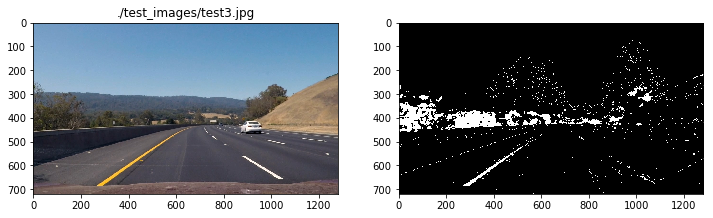

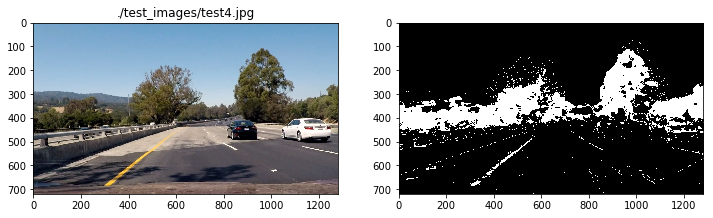

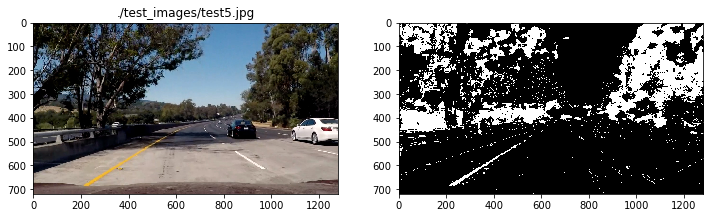

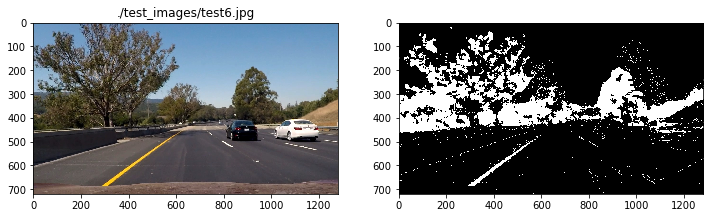

In [4]:
def abs_sobel_thresh(img, orient='x', thresh=(0,255)):
    ''' gradient threshold
    '''
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    ''' magnitude threshold
    '''
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # 3) Calculate the magnitude 
    #abs_sobelx = np.sqrt(np.square(sobelx))
    #abs_sobely = np.sqrt(np.square(sobely))
    abs_sobelxy = np.sqrt(np.square(sobelx) + np.square(sobely))
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    #binary_output = np.copy(img) # Remove this line
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    ''' direction threshold
    '''
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output

def color_threshold(img, thresh=(0, 255)):
    # Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS).astype(np.float)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    # Threshold color channel
    s_binary = np.zeros_like(S)
    s_binary[(H >= thresh[0]) & (H <= thresh[1])] = 1
    return s_binary

def filter(img, show_step=False):

    ksize = 3 # Choose a larger odd number to smooth gradient measurements

    #  Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', thresh=(20, 100))    
    grady = abs_sobel_thresh(image, orient='y', thresh=(20, 100))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(20, 100))
    dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))
    color_binary = color_threshold(img, thresh=(20,90))
    # combine filter
    combined = np.zeros_like(color_binary)
    combined[(color_binary == 1) | ((gradx == 1) & (grady == 1) & (mag_binary == 1) & (dir_binary == 1))] = 1
        
    if show_step:
        c1 = np.zeros_like(color_binary)
        c1[(color_binary == 1) | ((gradx == 1))] = 1

        c2 = np.zeros_like(color_binary)
        c2[(color_binary == 1) | ((gradx == 1) & (grady == 1))] = 1
        
        c3 = np.zeros_like(color_binary)
        c3[(color_binary == 1) | ((gradx == 1) & (grady == 1) & (mag_binary == 1))] = 1
    
        c4 = np.zeros_like(color_binary)
        c4[(color_binary == 1) | ((gradx == 1) & (grady == 1) & (mag_binary == 1) & (dir_binary == 1))] = 1

        plot_images(img, color_binary, 'original', 'color threshold')
        plot_images(gradx, grady, 'gradx','grady')
        plot_images(mag_binary, dir_binary, 'magnitude threshold', 'directional threshold')
        plot_images(c1,c2,'color gradx', 'color gradx grady')
        plot_images(c3,c4,'color gradx grady mag', 'color gradx grady mag dir')
    
    return combined


    
#image = cv2.imread('test_images/test5.jpg')
#after = filter(image, True)
#plot_images(image, after)

fnames = glob.glob('./test_images/*.jpg')
for fname in fnames:
    img = cv2.imread(fname)
    after = filter(img)
    plot_images(img, after, fname)


## Perspective Transform

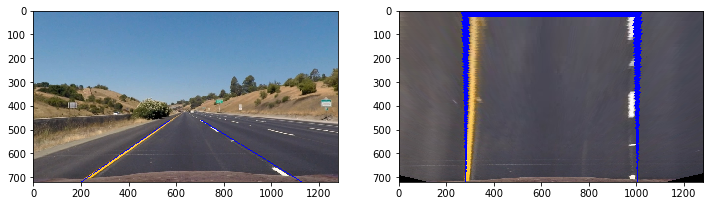

In [5]:
src = np.float32([
    (575,460),
    (705,460),
    (1130, 720),
    (200, 720)
])

dst = np.float32([
    (280, 0),
    (1000, 0),
    (1000, 720),
    (280, 720)
])

def warp(img, src, dst):
    ''' computer and apply perspective transform
    '''
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)
    return warped

def create_birds_eye_view(img):
    return warp(img, src, dst)

img = cv2.imread('./test_images/straight_lines1.jpg')
img = undistort(img)
draw_trapezoid(img, src)
warped = create_birds_eye_view(img)
plot_images(img, warped)

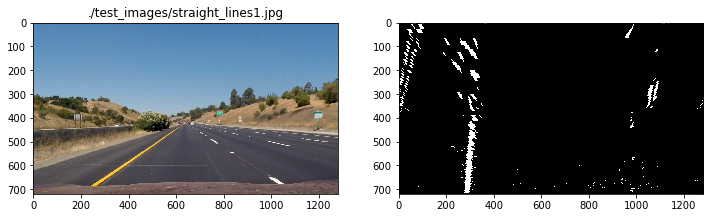

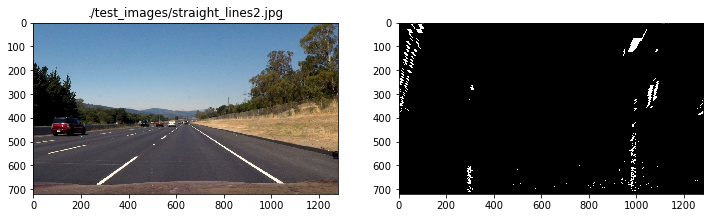

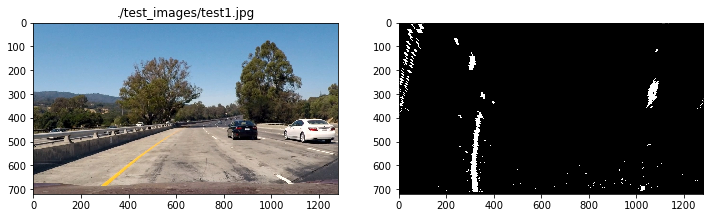

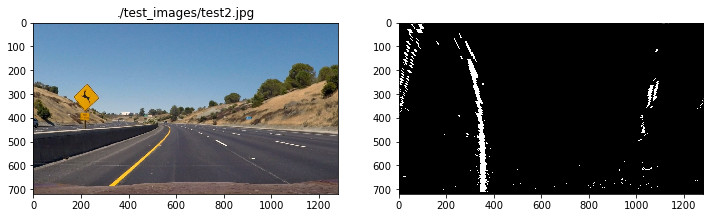

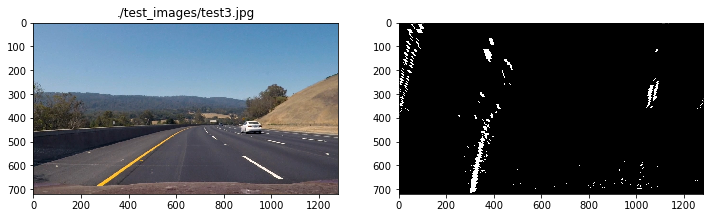

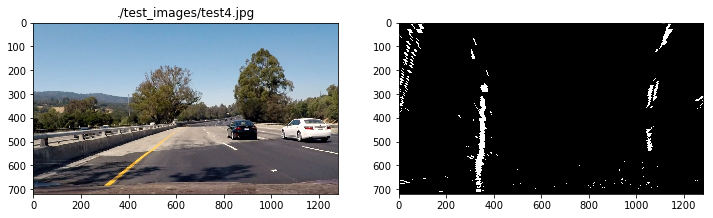

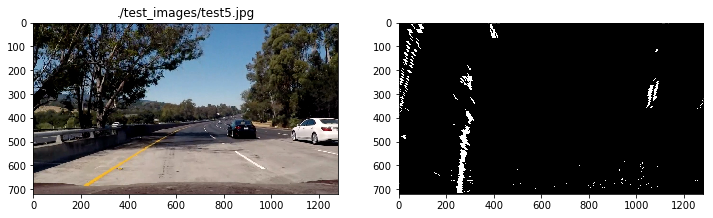

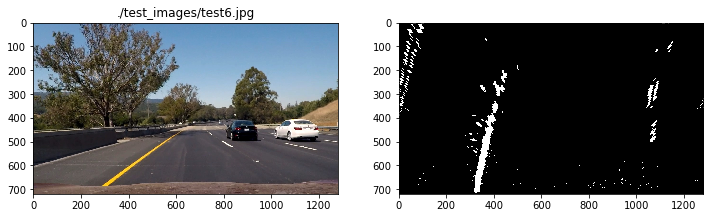

In [6]:
# test pipeline

fnames = glob.glob('./test_images/*.jpg')

for fname in fnames:
    original = cv2.imread(fname)
    img = np.copy(original)
    img = undistort(img)
    img = filter(img)
    img = create_birds_eye_view(img)
    #draw_trapezoid(original, src)
    plot_images(original, img, fname)

## Locate Lane Lines